In [1]:
import pandas as pd
import numpy as np
from path import Path
import torch.utils.data as data
from imageio import imread
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F 
import matplotlib.pyplot as plt
%matplotlib inline 
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import *
import ast

In [2]:
import os
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [4]:
from torch import nn
import numpy as np
from torch import nn
from path import Path
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
import torch.nn.functional as F
df=pd.DataFrame()
azz={}

In [5]:
def plot_roc(y_test,y_score,n_classes):
    
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    lb = LabelBinarizer()
    y_test=lb.fit_transform(y_test)
    
    y_test = np.hstack((1 - y_test, y_test))
    
#     y_test=lb.inverse_transform(y_test[:, 0])
#     print(y_test.shape)
#     print(y_test)    
#     print(y_test[:, 0])
#     print(y_score[:, 0])
#     print(y_score[:, 1])
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    plt.figure()
    lw = 2
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    azz['fpr']=fpr['macro']
    azz['tpr']=tpr['macro']

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    print(n_classes,"yes")
    for i, color in zip(range(n_classes), colors):
        print(i)
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('3D X LSTM X MLP  FOR  PROSTATE  DATASET')
    plt.legend(loc="lower right")
    plt.show()

In [6]:
import numpy as np

class ScaledDotProductAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''
    # given query, key,value it finds the rightful weighted component of v to get the attention applied ouput
    #q,v,k- batch X length of sequence X features or encoding
    #attention sholuld be -batchX7X7
    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, q, k, v, mask=None):
#         print(k.transpose(1,2).shape)

        attn = torch.bmm(q, k.transpose(1, 2)) 
#         print(attn.shape)
        attn = attn / self.temperature

        if mask is not None:
            attn = attn.masked_fill(mask, -np.inf)

        attn = self.softmax(attn)
        attn = self.dropout(attn)
#         print(str(attn.shape)+" "+str(v.shape))
        output = torch.bmm(attn, v)

        return output, attn
SDP=ScaledDotProductAttention(5)
Ss=SDP(torch.zeros(5,6,100),torch.zeros(5,6,100),torch.zeros(5,6,100))
# print(Ss[0].shape)
class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k)
        self.w_ks = nn.Linear(d_model, n_head * d_k)
        self.w_vs = nn.Linear(d_model, n_head * d_v)
        nn.init.normal_(self.w_qs.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_k)))
        nn.init.normal_(self.w_ks.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_k)))
        nn.init.normal_(self.w_vs.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_v)))

        self.attention = ScaledDotProductAttention(temperature=np.power(d_k, 0.5))
        self.layer_norm = nn.LayerNorm(d_model)

        self.fc = nn.Linear(n_head * d_v, d_model)
        nn.init.xavier_normal_(self.fc.weight)

        self.dropout = nn.Dropout(dropout)


    def forward(self, q, k, v, mask=None):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head

        sz_b, len_q, _ = q.size()
        sz_b, len_k, _ = k.size()
        sz_b, len_v, _ = v.size()
#         print(str(sz_b)+"die")

        residual = q

        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        q = q.permute(2, 0, 1, 3).contiguous().view(-1, len_q, d_k) # (n*b) x lq x dk
        k = k.permute(2, 0, 1, 3).contiguous().view(-1, len_k, d_k) # (n*b) x lk x dk
        v = v.permute(2, 0, 1, 3).contiguous().view(-1, len_v, d_v) # (n*b) x lv x dv
#         print("v-"+str(v.shape))
        if mask is not None:
            mask = mask.repeat(n_head, 1, 1) # (n*b) x .. x ..
        output, attn = self.attention(q, k, v, mask=mask)
#         print(q.shape,k.shape,v.shape)
        output = output.view(n_head, sz_b, len_q, d_v)
        output = output.permute(1, 2, 0, 3).contiguous().view(sz_b, len_q, -1) # b x lq x (n*dv)

        output = self.dropout(self.fc(output))
        output = self.layer_norm(output + residual)

        return output, attn
MHA=MultiHeadAttention(4,15,15,15)
op=MHA(torch.zeros(5,7,15),torch.zeros(5,7,15),torch.zeros(5,7,15))
# print(op[0].shape)
class PositionwiseFeedForward(nn.Module):
    ''' A two-feed-forward-layer module '''

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Conv1d(d_in, d_hid, 1) # position-wise
        self.w_2 = nn.Conv1d(d_hid, d_in, 1) # position-wise
        self.layer_norm = nn.LayerNorm(d_in)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        output = x.transpose(1, 2)
#         print("FCC-"+str(output.shape))
#         print("FFC_out-"+str(self.w_1(output).shape))
        output = self.w_2(F.relu(self.w_1(output)))
        output = output.transpose(1, 2)
        output = self.dropout(output)
        output = self.layer_norm(output + residual)
        return output

    

In [7]:
class EncoderLayer(nn.Module):
    ''' Compose with two layers '''

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(
            n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(self, enc_input, non_pad_mask=None, slf_attn_mask=None):
        enc_output, enc_slf_attn = self.slf_attn(
            enc_input, enc_input, enc_input, mask=slf_attn_mask)
#         print("ENC_o")
#         print(enc_output.shape)


        enc_output = self.pos_ffn(enc_output)


        return enc_output, enc_slf_attn
    
XX=EncoderLayer(15,10,4,10,10)

zz=XX(torch.zeros(5,7,15))
# print("ENc")
# print(zz[0].shape)
# print("start")
class Encoder(nn.Module):
    ''' A encoder model with self attention mechanism. '''

    def __init__(self,n_modality,d_model,n_head,d_k,d_v,dropout,n_layers,d_inner=500):
        #d_model - number of features in input 100 here
        #n_head - number of heads of multihaded attention
        #d_k=d_q=  number of features in query, key
        #d_v = number of features in value whose weighted(attentioned) sum we gonna take
        

        super().__init__()
        self.n_modality=n_modality
#         self.stn=nn.ModuleList([SpatialTransformer(3, (240,240), 8) for _ in range(n_ref)])
        
        self.layer_stack = nn.ModuleList([EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout) 
                                          for _ in range(n_layers)])
        self.em=nn.Linear(32,100)
        #self.em1=nn.Linear(225,100)
        self.fc1=nn.Linear(d_model*n_modality,300)
        self.relu=nn.ReLU()
        self.fc2=nn.Linear(300,100)
        self.fc3=nn.Linear(100,2)
#         self.fc4=nn.Linear(50,3)
        self.bn1 = nn.BatchNorm1d(num_features=300)
        self.bn2 = nn.BatchNorm1d(num_features=100)
        self.softmax=nn.Softmax(1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, embeddings1,embeddings2,embeddings3 ):#mlpxlstmx3d


        
        encodings_total=[embeddings1,embeddings2,self.em(embeddings3)]

        enc_output=torch.stack(encodings_total,0)

        
        enc_output=enc_output.permute(1,0,2)
#         print("encoding_OUTPUT2-"+str(enc_output.shape))

        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn = enc_layer(enc_output,non_pad_mask=None,slf_attn_mask=None)
           
        
        final_input=enc_output.reshape(enc_output.shape[0],-1)

        final=self.relu(self.fc3(self.bn2(self.relu((self.fc2(self.bn1(self.relu(self.fc1(final_input)))))))))
        
        return(final)
     

In [8]:
e1=torch.zeros(4,100)
e2=torch.zeros(4,100)
e3=torch.stack([e1,e2],0)
e3.shape

torch.Size([2, 4, 100])

In [9]:
feature_set_MLP=pd.read_csv('Prostrate_MLP_features_ankit.csv')
feature_set_3d=pd.read_csv('Ankitprostate_3d.csv')
feature_set_LSTM=pd.read_csv('prostrate_LSTM_features_ankit.csv')
feature_set_3d.head()

,gene_name,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,...,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28,tag_29,tag_30,tag_31
0,vhl,-0.004627,0.245317,0.004466,0.069272,-0.003327,-0.263032,-0.003749,0.251758,-0.003560,...,0.003328,-0.229637,0.004711,0.266983,-0.003079,0.228596,0.003680,-0.258568,-0.003935,0.195633
1,ndufa10,0.275199,0.009126,-0.289780,0.004290,0.173320,-0.012266,0.259847,0.010369,0.283457,...,-0.258688,-0.011406,-0.293413,0.009331,0.251243,0.009058,-0.211729,-0.013103,0.264524,0.007954
2,ube4b,0.290513,0.000389,-0.282832,0.000397,0.173428,-0.000026,0.258021,-0.000054,0.284236,...,-0.266636,-0.000551,-0.294954,0.000467,0.244364,0.000293,-0.203645,-0.000146,0.275976,0.000081
3,foxo3,0.281134,0.000155,-0.286166,0.000090,0.173116,-0.000050,0.261762,0.000328,0.288521,...,-0.266013,-0.000130,-0.291289,0.000215,0.253075,0.000154,-0.203884,-0.000096,0.268459,-0.000015
4,rap2a,0.000149,0.245117,-0.000038,0.066403,-0.000030,-0.267965,-0.000021,0.249047,0.000241,...,-0.000095,-0.223775,0.000131,0.271736,-0.000234,0.235593,0.000200,-0.267288,0.000179,0.193028


In [10]:
feature_set_MLP.head()

,gene_name,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,...,tag_90,tag_91,tag_92,tag_93,tag_94,tag_95,tag_96,tag_97,tag_98,tag_99
0,vhl,0.000000,0.000000,0.0,22.241405,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,10.266189
1,smox,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,7.911898,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,12.720570,0.000000
2,znf148,0.000000,0.000000,0.0,21.678095,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,10.640351
3,map4k2,20.404165,23.852463,0.0,0.000000,43.247234,0.0,31.033705,0.203660,56.684559,...,0.000000,18.108454,0.0,0.0,0.0,28.755461,5.603198,13.697145,63.017044,0.000000
4,mapk4,42.203545,52.076824,0.0,0.000000,89.526337,0.0,67.578827,10.026752,108.900192,...,3.838364,40.393089,0.0,0.0,0.0,57.628872,18.609310,32.895622,120.597061,0.000000


In [11]:
header_of_MLP=['tag_'+str(i) for i in range(feature_set_MLP.shape[1]-1)]
features_MLP=np.array(feature_set_MLP[header_of_MLP])
gene_MLP=feature_set_MLP['gene_name']
print(features_MLP.shape)
print(len(gene_MLP))

(2424, 100)
2424


In [12]:
dictionary_MLP={}
u=0
for gn in gene_MLP:
    dictionary_MLP[gn]=features_MLP[u]
    u=u+1

In [13]:
header_of_3d=['tag_'+str(i) for i in range(feature_set_3d.shape[1]-1)]
features_3d=np.array(feature_set_3d[header_of_3d])
gene_3d=feature_set_3d['gene_name']
print(features_3d.shape)
print(len(gene_3d))


(723, 32)
723


In [14]:
dictionary_3d={}
u=f=0
for gn in gene_3d:
    if gn in dictionary_3d.keys():
#         print(gn)
        f=f+1
    dictionary_3d[gn]=features_3d[u]
    u=u+1
print(u)

723


In [15]:
print(len(dictionary_3d.keys()))

676


In [16]:
header_of_lstm=['tag_'+str(i) for i in range(feature_set_LSTM.shape[1]-1)]
features_lstm=np.array(feature_set_LSTM[header_of_lstm])
gene_lstm=feature_set_LSTM['gene_name']
print(features_lstm.shape)
print(len(gene_lstm))

(1763, 100)
1763


In [17]:
dictionary_lstm={}
u=f=0
for gn in gene_lstm:
    if gn in dictionary_lstm.keys():
#         print(gn)
        f=f+1
    dictionary_lstm[gn]=features_lstm[u]
    u=u+1
print(u)

1763


In [18]:
fil=open('../../Multi-modality/Model/Prostrate/uni model/MLP/Labels_prostate.txt','r')
tmp=list()
for line in fil:
	tmp.append(int(line))

label_PROSTATE=np.array(tmp)
print(label_PROSTATE.shape)

(2424,)


In [22]:
class Sequenceloader(data.Dataset):
    def __init__(self,GN,label,Feat):
        self.gene_names=GN
        self.features_mlp=Feat
        self.label=label
        self.coincdgene_name=[]
        self.coincidfeature_lstm=[]
        self.coincidfeature_3d=[]
        self.coincidfeature_mlp=[]
        self.coincidlabel=[]
        for i in range(len(self.gene_names)):
            u=self.gene_names[i]
            if u in dictionary_3d.keys() and u in dictionary_lstm.keys():
                
                if np.array(self.label[i])==2:
                    ch=1
                else:
                    ch=1
                    
                for jj in range(ch):
                    self.coincdgene_name.append(u)
                    self.coincidfeature_lstm.append(dictionary_lstm[u])
                    self.coincidfeature_3d.append(dictionary_3d[u])
                    self.coincidlabel.append(self.label[i])
                    self.coincidfeature_mlp.append(self.features_mlp[i])
        
        
    
    def __len__(self):
#         print(len(self.dataset))
        return len(self.coincdgene_name)       

    def __getitem__(self, index):
         return np.array(self.coincidfeature_mlp[index]),np.array(self.coincidfeature_lstm[index]),np.array(self.coincidfeature_3d[index]),np.array(self.coincidlabel[index])
#         print(self.dataset['gen_name'][index])          
#         try:
           
#         except :
            
total_set=Sequenceloader(gene_MLP,label_PROSTATE,features_MLP)  
a=b=c=0
for x1,x2,x3,z in total_set:
    if(z==0):
        a=a+1
    elif z==1:
        b=b+1
    else:
        c=c+1
print(a,b,c)
    

309 414 0


In [20]:
batch_size = 4
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(total_set)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(total_set, batch_size=batch_size, 
                                           sampler=train_sampler,drop_last=True)
validation_loader = torch.utils.data.DataLoader(total_set, batch_size=batch_size,
                                                sampler=valid_sampler,drop_last=True)


In [21]:
for a,b,c,d in train_loader:
    print(a.shape,b.shape,c.shape,d.shape)

torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4, 32]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4, 32]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4, 32]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4, 32]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4, 32]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4, 32]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4, 32]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4, 32]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4, 32]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4, 32]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4, 32]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4, 32]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4, 32]) to

In [22]:
device='cpu'
model_3dXLSTMXMLP=Encoder(3,100,4,300,300,True,4).to(device)
model_3dXLSTMXMLP.load_state_dict(torch.load(Path('1AnkitPROSTATE_COMBO_3DXLSTMXMLP.pt'),map_location='cpu'))
uz=vz=torch.rand(4,100).to(device)
# model_3dXMLP(uz,vz).shape


In [23]:

# model.load_state_dict(torch.load(Path('currentz_m1_epoch.pt')))
optim_params = [
    {'params': model_3dXLSTMXMLP.parameters(), 'lr': 0.0001}
]
optimizer = torch.optim.Adam(optim_params)
criterion = nn.CrossEntropyLoss()

In [24]:
y_test=[]
y_score=[]
total_imgs=0;
total_corrects=0
u=0
nb_classes=3
confusion_matrix = torch.zeros(nb_classes, nb_classes)
for i1,i2,i3,label in validation_loader:


    output=model_3dXLSTMXMLP(i1.to(device).float(),i2.to(device).float(),i3.to(device).float())
    y_test.append(label)
    y_score.append(output)
    total_imgs=total_imgs+label.shape[0]
    z=torch.max(output,1)[1]==label.to(device)
    _, preds = torch.max(output, 1)
#         print(output.shape)

    num_corrects=torch.sum(z)
    total_corrects=total_corrects+num_corrects
    for t, p in zip(label.view(-1), preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1


    u=u+1


print(confusion_matrix)
print(total_corrects,total_imgs)
    
        
        

tensor([[53., 10.,  0.],
        [ 3., 78.,  0.],
        [ 0.,  0.,  0.]])
tensor(131) 144


In [25]:
print(torch.cat(y_score,0).shape)
print(torch.cat(y_test,0).shape)

torch.Size([144, 2])
torch.Size([144])


2 yes
0
1


<Figure size 432x288 with 0 Axes>

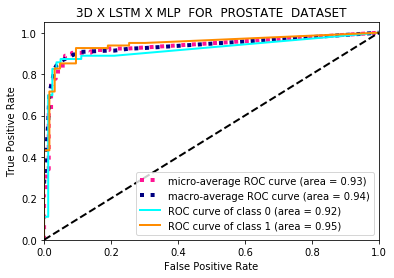

In [26]:
plot_roc(torch.cat(y_test,0).numpy(),torch.cat(y_score,0).cpu().detach().numpy(),2)

In [27]:
!nvidia-smi
tensor([[56.,  7.],
        [ 7., 74.]])
Accuracy-(tensor(130, device='cuda:7'), 144)

Tue Jun 25 14:00:50 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0  On |                  N/A |
|  0%   31C    P8    17W / 250W |   2083MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
| 24%   44C    P2    56W / 250W |   4630MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

NameError: name 'tensor' is not defined

In [28]:

dataset = pd.DataFrame({'fpr':azz['fpr'],'tpr':azz['tpr']})

In [29]:
dataset.to_csv('prostrate_3dXlstmXmlp_roc.csv')